In [1]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import statsmodels.api as sm
import geopandas as gpd
import os
import dask
import dask.dataframe as dd
import itertools
from itertools import chain
from math import sqrt, floor, ceil, isnan
import multiprocess
import multiprocessing
import importlib
from importlib import reload
from collections import Counter
from fuzzywuzzy import process, fuzz
import time
import warnings
import datetime
from datetime import datetime
from datetime import date
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
warnings.filterwarnings("error")

pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 400

try:
    del(FUN_proc_name)
except:
    pass
import FUN_proc_name
importlib.reload(FUN_proc_name)
from FUN_proc_name import FUN_proc_name


# 1. Add Parent Information, Geographic Delineation and Other Variables

In [2]:
# Import GPF
GPF = pd.read_csv("../CleanData/SDC/0A_GPF.csv",low_memory=False)
if 'Unnamed: 0' in GPF.columns:
    GPF = GPF.drop(columns=['Unnamed: 0'])

# Generate cleaned names
raw_name_GPF_colnames = [column for column in GPF.columns if 'raw_name_GPF_' in column]
idx = 0
for column in raw_name_GPF_colnames:
    GPF['name_GPF_'+str(idx)] = GPF[column].apply(FUN_proc_name)
    idx = idx+1
name_GPF_colnames = ['name_GPF_'+str(idx) for idx in range(0,len(raw_name_GPF_colnames))]

# Hand corrections
# Change "CHEMICAL BANK" to "CHEMICAL BANK MICHIGAN" for deals in MI
GPF.loc[(GPF['lead_manager'].str.contains('Chemical Bank'))&(GPF['State']=='MI'),'lead_manager'] = 'CHEMICAL BANK MICHIGAN'
for column in raw_name_GPF_colnames:
    GPF.loc[(GPF['raw_name_GPF_0'].str.contains('Chemical Bank'))&(GPF['State']=='MI'),column] = 'CHEMICAL BANK MICHIGAN'

# Sometimes name of an entity that arise due to merger appear prior to merger
GPF.loc[(GPF['lead_manager']=='Dean Witter Reynolds Inc.')&(GPF['sale_year']<1978),'lead_manager'] = 'Dean Witter'
for column in raw_name_GPF_colnames:
    GPF.loc[(GPF['raw_name_GPF_0']=='Dean Witter Reynolds Inc.')&(GPF['sale_year']<1978),column] = 'Dean Witter'

GPF.loc[(GPF['lead_manager']=='Prescott, Ball & Turben, Inc.')&(GPF['sale_year']<1973),'lead_manager'] = 'Prescott, Merrill, Turben'
for column in raw_name_GPF_colnames:
    GPF.loc[(GPF['raw_name_GPF_0']=='Prescott, Ball & Turben, Inc.')&(GPF['sale_year']<1973),column] = 'Prescott, Merrill, Turben'

# Whether dual advisor/underwriter
GPF['raw_advisor_long'] = GPF['advisor_long']
GPF['raw_advisor_short'] = GPF['advisor_short']
GPF['advisor_long'] = GPF['advisor_long'].apply(FUN_proc_name)
GPF['advisor_short'] = GPF['advisor_short'].apply(FUN_proc_name)
GPF['if_dual_advisor'] = False
for col in name_GPF_colnames:
    GPF['if_dual_advisor'] = (GPF['if_dual_advisor'])|(GPF['advisor_long']==GPF[col])


In [3]:
# Winsorize data. Handle missing values cases carefully

vars_to_winsor = [
    'gross_spread','gross_spread_tic_based','gross_spread_nic_based','tic_nic_based',
    'avg_yield','treasury_avg_spread','MMA_avg_spread',
    'net_interest_cost','true_interest_cost',
    ]

for var in vars_to_winsor:
    GPF[var] = pd.to_numeric(GPF[var],errors='coerce')
    upper_limit = np.percentile(GPF[var][np.logical_not(np.isnan(GPF[var]))],99)
    lower_limit = np.percentile(GPF[var][np.logical_not(np.isnan(GPF[var]))],1)
    GPF.loc[(GPF[var]>upper_limit)&(np.logical_not(np.isnan(GPF[var]))),var] = upper_limit
    GPF.loc[(GPF[var]<lower_limit)&(np.logical_not(np.isnan(GPF[var]))),var] = lower_limit


## 1.1 Geographic delineation

In [4]:
#-------------#
# Import CBSA #
#-------------#

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

# "CSA" is for metropolitan and "CBSA" includes also those micropolitan
CBSAData = pd.read_excel("../RawData/MSA/CBSA.xlsx",skiprows=[0,1])
CBSAData = CBSAData[~pd.isnull(CBSAData['County/County Equivalent'])]

# Add state abbreviations
us_state_to_abbrev = pd.DataFrame.from_dict(us_state_to_abbrev,orient='index').reset_index()
us_state_to_abbrev.columns = ['State Name','State']
CBSAData = CBSAData.rename(columns={'County/County Equivalent':'County'})
CBSAData = CBSAData.merge(us_state_to_abbrev,on='State Name',how='outer',indicator=True)
CBSAData = CBSAData[CBSAData['_merge']=='both'].drop(columns=['_merge'])
# Merge is perfect
CBSAData['County'] = CBSAData['County'].str.upper()
CBSAData['County'] = CBSAData['County'].str.replace(' COUNTY','')
CBSAData['County'] = CBSAData['County'].str.replace(' AND ',' & ')
CBSAData['County'] = CBSAData['County'].str.replace('.','',regex=False)
CBSAData['CSA Code'] = CBSAData['CSA Code'].astype(float)
CBSAData['CBSA Code'] = CBSAData['CBSA Code'].astype(float)



#######################
# Merge GPF with CBSA #
#######################

# First try to merge with first item before '/'
GPF = GPF.reset_index(drop=True)
GPF = GPF[~pd.isnull(GPF['County'])]
for idx,row in GPF.iterrows():
    if '/' in row['County']:
        GPF.at[idx,'County'] = row['County'].split('/')[0]
GPF = GPF.merge(CBSAData[['CBSA Code','CSA Code','CBSA Title','CSA Title','County','State']],
    on=['County','State'],how='outer',indicator=True)

GPF = GPF[GPF['State']!='nan']
GPF = GPF[GPF['State']!='AS']
GPF = GPF[GPF['State']!='DC']
GPF = GPF[GPF['State']!='FF']
GPF = GPF[GPF['State']!='GU']
GPF = GPF[GPF['State']!='MR']
GPF = GPF[GPF['State']!='PR']
GPF = GPF[GPF['State']!='TT']
GPF = GPF[GPF['State']!='VI']

# Notes:
# Most cases it is because a county does not belong to any CBSA: Out of 3,000 counties in US, only 2,000 in CBSAData.
# Sometimes other "/" items lead to the right match in CBSAData.
# Some "County" fields are occupied by cities or school districts.
# Many cases issuer is "STATE AUTHORITY" or "COLLEGE OR UNIVERSITY".

# Handle cases where other "/" items might lead to the right match in CBSA
for idx,row in GPF.iterrows():
    if type(row['County_raw'])==str:
        if (row['_merge']=='left_only')&('/' in row['County_raw']):
            for item in row['County_raw'].split('/'):
                item = item.upper()
                CBSA_frag = CBSAData[(CBSAData['County']==item)&(CBSAData['State']==row['State'])].reset_index()
                if len(CBSA_frag)>0:
                    GPF.at[idx,'CBSA Code'] = CBSA_frag['CBSA Code'][0]
                    GPF.at[idx,'CSA Code'] = CBSA_frag['CSA Code'][0]
                    GPF.at[idx,'CBSA Title'] = CBSA_frag['CBSA Title'][0]
                    GPF.at[idx,'CSA Title'] = CBSA_frag['CSA Title'][0]
                    GPF.at[idx,'_merge'] = 'both'
                    # No need to continue once a match is found
                    break

# Drop if year is missing
GPF = GPF[~pd.isnull(GPF['sale_year'])]
GPF['sale_year'] = GPF['sale_year'].astype(int)

## 1.2 Parent information

### 1.2.1 Generate parent-subsidiary relationship

In [5]:
# Get a list of underwriters names in GPF for each year
GPF_names = pd.DataFrame()
for year in range(1967,2024):
    GPF_oneyear = GPF[GPF['sale_year']==year]
    GPF_names_oneyear = GPF_oneyear[['lead_manager']].drop_duplicates()
    GPF_names_oneyear = GPF_names_oneyear.rename(columns={'lead_manager':'raw_name_GPF'})
    # Process those with multiple lead_managers
    GPF_names_oneyear_new = []
    for idx,row in GPF_names_oneyear.iterrows():
        if '\n' not in row['raw_name_GPF']:
            GPF_names_oneyear_new = GPF_names_oneyear_new+[{'raw_name_GPF':row['raw_name_GPF']}]
        else:
            for item in row['raw_name_GPF'].split('\n'):
                GPF_names_oneyear_new = GPF_names_oneyear_new+[{'raw_name_GPF':item}]
    GPF_names_oneyear = pd.DataFrame(GPF_names_oneyear_new)
    GPF_names_oneyear = GPF_names_oneyear[['raw_name_GPF']].drop_duplicates()
    # Process format
    GPF_names_oneyear['name_GPF'] = GPF_names_oneyear['raw_name_GPF'].apply(FUN_proc_name)
    GPF_names_oneyear['sale_year'] = year
    GPF_names = pd.concat([GPF_names,GPF_names_oneyear])

Notes:
- I am no longer interested in any parent-subsidiary relationships as I have hand-cleaned names. The only parent-subsidiary relationship that gets reflected in "GPF_names" are those that appear as M&As during sample period
- For every case, find the ultimate parent of the acquirer. Change the parent of the target to that for that year and every year afterwards. Then, look for any subsidiary of the target, and change their parent to the ultimate parent of the acquirer as well. Process this in a chronological order to account for scenarios where ownership changes over time for the same firm.

In [6]:
# Import investment bank M&As
MA = pd.read_parquet('../CleanData/SDC/0B_M&A.parquet')

try:
    GPF_names = GPF_names.drop(columns=['parent_raw_name_NIC','parent_name_NIC'])
except:
    pass
GPF_names['parent_name'] = GPF_names['name_GPF']

for idx,row in MA.iterrows():

    # Identify ultimate parent of the acquirer
    # If it is a parent firm or a standalone firm, then parent is itself. Otherwise, extract parent for that year
    GPF_names_frag = GPF_names[(GPF_names['name_GPF']==row['acquiror'])&(GPF_names['sale_year']==row['sale_year'])].reset_index()
    if len(GPF_names_frag)>0:
        if GPF_names_frag['parent_name'][0]!=row['acquiror']:
            acquirer_parent = GPF_names_frag['parent_name'][0]
        else:
            acquirer_parent = row['acquiror']
    else:
        acquirer_parent = row['acquiror']

    # Change parent of the target to the acquirer or its ultimate parent in every year afterwards
    GPF_names.loc[(GPF_names['name_GPF']==row['target'])&(GPF_names['sale_year']>=row['sale_year']),
        'parent_name'] = acquirer_parent

    # Change parent of any subsidiary of the target to the acquirer or its ultimate parent in every year afterwards
    GPF_names.loc[(GPF_names['parent_name']==row['target'])&(GPF_names['sale_year']>=row['sale_year']),
        'parent_name'] = acquirer_parent

GPF_names.to_parquet('../CleanData/SDC/0H_GPF_Parent.parquet')


### 1.2.2 Merge GPF with ultimate parent of underwriters

In [7]:

# Put ultimate parent names into "GPF"
GPF = GPF.drop(columns=['_merge'],errors='ignore')
GPF_names = pd.read_parquet('../CleanData/SDC/0H_GPF_Parent.parquet')
GPF_names = GPF_names[['name_GPF','parent_name','sale_year']]
GPF_names = GPF_names.drop_duplicates(['name_GPF','sale_year'])

# Add a column of cleaned underwriter names
column_ind = 0
raw_name_GPF_colnames = [column for column in GPF.columns if 'raw_name_GPF_' in column]
for column in raw_name_GPF_colnames:
    # Obtain the parent name
    # Note that this merge should be perfect. Check if it indeed is
    GPF = GPF.merge(GPF_names.rename(columns={'name_GPF':column[4:]}),on=[column[4:],'sale_year'],how='outer',indicator=True)
    GPF = GPF[(GPF['_merge']=='both')|(GPF['_merge']=='left_only')]
    GPF = GPF.drop(columns=['_merge'])
    GPF = GPF.rename(columns={'parent_name':'parent_name_'+str(column_ind)})
    column_ind = column_ind+1


## 1.3 Credit ratings

In [8]:
# Whether has rating
GPF['has_Moodys'] = \
    (GPF['Moodys_ILTR'].str.contains('A'))|(GPF['Moodys_ISTR'].str.contains('A'))|\
    (GPF['Moodys_ILTR'].str.contains('B'))|(GPF['Moodys_ISTR'].str.contains('B'))|\
    (GPF['Moodys_ILTR'].str.contains('C'))|(GPF['Moodys_ISTR'].str.contains('C'))
GPF['has_Fitch'] = \
    (GPF['Fitch_ILTR'].str.contains('A'))|(GPF['Fitch_ISTR'].str.contains('A'))|\
    (GPF['Fitch_ILTR'].str.contains('B'))|(GPF['Fitch_ISTR'].str.contains('B'))|\
    (GPF['Fitch_ILTR'].str.contains('C'))|(GPF['Fitch_ISTR'].str.contains('C'))|\
    (GPF['Fitch_ILTR'].str.contains('D'))|(GPF['Fitch_ISTR'].str.contains('D'))

def proc_list(GPF):

    GPF = GPF.copy()
    
    # Ratings in numerical score. Take the best rating
    GPF['rating_Moodys'] = None
    for idx,row in GPF.iterrows():
        if str(row['Moodys_ILTR'])=='None' or str(row['Moodys_ISTR'])=='nan':
            continue
        if 'Aaa' in row['Moodys_ILTR'] or 'Aa1' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 0
        elif 'Aa1' in row['Moodys_ILTR'] or 'Aa1' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 1
        elif 'Aa2' in row['Moodys_ILTR'] or 'Aa2' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 2
        elif 'Aa3' in row['Moodys_ILTR'] or 'Aa3' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 3
        elif 'A1' in row['Moodys_ILTR'] or 'A1' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 4
        elif 'A2' in row['Moodys_ILTR'] or 'A2' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 5
        elif 'A3' in row['Moodys_ILTR'] or 'A3' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 6
        elif 'Baa1' in row['Moodys_ILTR'] or 'Baa1' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 7
        elif 'Baa2' in row['Moodys_ILTR'] or 'Baa2' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 8
        elif 'Baa3' in row['Moodys_ILTR'] or 'Baa3' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 9
        elif 'Ba1' in row['Moodys_ILTR'] or 'Ba1' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 10
        elif 'Ba2' in row['Moodys_ILTR'] or 'Ba2' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 11
        elif 'Ba3' in row['Moodys_ILTR'] or 'Ba3' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 12
        elif 'B1' in row['Moodys_ILTR'] or 'B1' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 13
        elif 'B2' in row['Moodys_ILTR'] or 'B2' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 14
        elif 'B3' in row['Moodys_ILTR'] or 'B3' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 15
        elif 'Caa1' in row['Moodys_ILTR'] or 'Caa1' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 16
        elif 'Caa2' in row['Moodys_ILTR'] or 'Caa2' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 17
        elif 'Caa3' in row['Moodys_ILTR'] or 'Caa3' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 18
        elif 'Ca' in row['Moodys_ILTR'] or 'Ca' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 19
        elif 'C' in row['Moodys_ILTR'] or 'C' in row['Moodys_ISTR']:
            GPF.at[idx,'rating_Moodys'] = 20
    
    GPF['rating_Fitch'] = None
    for idx,row in GPF.iterrows():
        if str(row['Fitch_ILTR'])=='None' or str(row['Fitch_ISTR'])=='nan':
            continue
        if 'AAA' in row['Fitch_ILTR'] or 'AAA' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 0
        elif 'AA+' in row['Fitch_ILTR'] or 'AA+' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 1
        elif 'AA' in row['Fitch_ILTR'] or 'AA' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 2
        elif 'AA-' in row['Fitch_ILTR'] or 'AA-' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 3
        elif 'A+' in row['Fitch_ILTR'] or 'A+' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 4
        elif 'A' in row['Fitch_ILTR'] or 'A' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 5
        elif 'A-' in row['Fitch_ILTR'] or 'A-' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 6
        elif 'BBB+' in row['Fitch_ILTR'] or 'BBB+' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 7
        elif 'BBB' in row['Fitch_ILTR'] or 'BBB' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 8
        elif 'BBB-' in row['Fitch_ILTR'] or 'BBB-' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 9
        elif 'BB+' in row['Fitch_ILTR'] or 'BB+' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 10
        elif 'BB' in row['Fitch_ILTR'] or 'BB' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 11
        elif 'BB-' in row['Fitch_ILTR'] or 'BB-' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 12
        elif 'B+' in row['Fitch_ILTR'] or 'B+' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 13
        elif 'B' in row['Fitch_ILTR'] or 'B' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 14
        elif 'B-' in row['Fitch_ILTR'] or 'B-' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 15
        elif 'CCC+' in row['Fitch_ILTR'] or 'CCC+' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 16
        elif 'CCC' in row['Fitch_ILTR'] or 'CCC' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 17
        elif 'CCC-' in row['Fitch_ILTR'] or 'CCC-' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 18
        elif 'CC+' in row['Fitch_ILTR'] or 'CC+' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 19
        elif 'CC' in row['Fitch_ILTR'] or 'CC' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 20
        elif 'CC-' in row['Fitch_ILTR'] or 'CC-' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 21
        elif 'C+' in row['Fitch_ILTR'] or 'C+' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 22
        elif 'C' in row['Fitch_ILTR'] or 'C' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 22
        elif 'C-' in row['Fitch_ILTR'] or 'C-' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 23
        elif 'D+' in row['Fitch_ILTR'] or 'D+' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 24
        elif 'D' in row['Fitch_ILTR'] or 'D' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 25
        elif 'D-' in row['Fitch_ILTR'] or 'D-' in row['Fitch_ISTR']:
            GPF.at[idx,'rating_Fitch'] = 16

    return GPF

meta_columns = list(proc_list(GPF[:10]).columns)
GPF_dd = dd.from_pandas(GPF, npartitions=20)
with dask.config.set(scheduler='processes',num_workers=20):
    GPF = GPF_dd.map_partitions(proc_list,meta=pd.DataFrame(columns=meta_columns)).compute()


## 1.4 Measure previous relationships with underwriters

In [9]:
%%time

# Generate a issuer X year level dataset of how many underwriters the isser has worked with in the previous ten (or other length of period)
# years. This is a cross-section to be examined.
num_relationships = []
GPF_gb = GPF.groupby(['Issuer'])

parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]

for issuer in list(GPF_gb.groups.keys()):
    GPF_oneissuer = GPF_gb.get_group(issuer)

    # Only calculate previous relationship for years when issuers are issuing
    years_relevant = GPF_oneissuer['sale_year'].unique()
    for year in years_relevant:
        GPF_oneissuer_part = GPF_oneissuer[(GPF_oneissuer['sale_year']<year)&(GPF_oneissuer['sale_year']>=year-10)]
        if len(GPF_oneissuer_part)==0:
            num_relationships = num_relationships+[{'Issuer':issuer,'sale_year':year,'num_relationship':0}]
        else:
            parent_name_GPFs = list(chain.from_iterable(list(np.array(GPF_oneissuer_part[parent_name_colnames]))))
            parent_name_GPFs = [item for item in parent_name_GPFs if item!=None]
            parent_name_GPFs = [item for item in parent_name_GPFs if str(item)!='nan']
            parent_name_GPFs = list(set(parent_name_GPFs))
            num_relationships = num_relationships+[{'Issuer':issuer,'sale_year':year,'num_relationship':len(parent_name_GPFs)}]

num_relationships = pd.DataFrame(num_relationships)
num_relationships = num_relationships.drop_duplicates()

# Merge into GPF
GPF = GPF.merge(num_relationships,on=['Issuer','sale_year'])

CPU times: user 6min 32s, sys: 22.9 s, total: 6min 55s
Wall time: 6min 55s


## 1.5 Measure if prior relationship with advisor, rater, and insurer

In [10]:
def proc_list(GPF):

    GPF = GPF.copy()
    GPF = GPF.reset_index()
    GPF_gb = GPF.groupby('Issuer')
    
    GPF['if_prior_insurer'] = None
    GPF['if_prior_advisor'] = None
    GPF['if_prior_rater'] = None
    
    for idx,row in GPF.iterrows():
    
        GPF_oneissuer = GPF_gb.get_group(row['Issuer'])
        # Check all prior issues of the same issuer
        GPF_oneissuer = GPF_oneissuer[GPF_oneissuer['sale_year']<row['sale_year']]
    
        prior_insurers = list(GPF_oneissuer['credit_enhancer_short'].unique())
        prior_insurers = [item for item in prior_insurers if item!=None]
        prior_insurers = [item for item in prior_insurers if str(item)!='nan']
        prior_insurers = [item for item in prior_insurers if str(item)!='None']
        prior_insurers = [item for item in prior_insurers if str(item)!='NONE']
        if_prior_insurer = row['credit_enhancer_short'] in prior_insurers
        GPF.at[idx,'if_prior_insurer'] = if_prior_insurer
    
        prior_advisors = list(GPF_oneissuer['advisor_short'].unique())
        prior_advisors = [item for item in prior_advisors if item!=None]
        prior_advisors = [item for item in prior_advisors if str(item)!='nan']
        prior_advisors = [item for item in prior_advisors if str(item)!='None']
        prior_advisors = [item for item in prior_advisors if str(item)!='NONE']
        if_prior_advisor = row['advisor_short'] in prior_advisors
        GPF.at[idx,'if_prior_advisor'] = if_prior_advisor
    
        if_prior_rater = False
        
        prior_fitch_rating = list(GPF_oneissuer['rating_Fitch'].unique())
        prior_fitch_rating = [item for item in prior_fitch_rating if item!=None]
        prior_fitch_rating = [item for item in prior_fitch_rating if str(item)!='nan']
        prior_fitch_rating = [item for item in prior_fitch_rating if str(item)!='None']
        prior_fitch_rating = [item for item in prior_fitch_rating if str(item)!='NONE']
        if len(prior_fitch_rating)>0:
            if_prior_rater = True
    
        prior_moodys_rating = list(GPF_oneissuer['rating_Moodys'].unique())
        prior_moodys_rating = [item for item in prior_moodys_rating if item!=None]
        prior_moodys_rating = [item for item in prior_moodys_rating if str(item)!='nan']
        prior_moodys_rating = [item for item in prior_moodys_rating if str(item)!='None']
        prior_moodys_rating = [item for item in prior_moodys_rating if str(item)!='NONE']
        if len(prior_moodys_rating)>0:
            if_prior_rater = True
    
        GPF.at[idx,'if_prior_rater'] = if_prior_rater

    return GPF

GPF = GPF.set_index('Issuer')
meta_columns = list(proc_list(GPF[:100]).columns)
GPF_dd = dd.from_pandas(GPF, npartitions=40)
with dask.config.set(scheduler='processes',num_workers=40):
    GPF = GPF_dd.map_partitions(proc_list,meta=pd.DataFrame(columns=meta_columns)).compute()


## 1.6 Identify expertise of underwriters

In [11]:
# Whether underwriter is an expert in terms of 
# (1) Competitive bidding versus negotiated sales.
# (2) Large bonds or small bonds.
# (3) Long or short maturity bonds.
# (4) By purpose of bond according to SDC.
# (5) By rated versus non-rated, and ratings level.

# Using previous data, calculate the ratio of an underwriter's market share within a class of bonds to
# an underwriter's market share within the whole market. Then rank underwriters and obtain indicators for quantiles,
# both when sorted across the whole country (using prior three years' data, or when sorted within an area 
# (using prior ten years' data).

# Then, for each bond in each "local M&A episode", I can identify whether the merging underwriters is in the specific
# sub-market that this bond issue belongs to.



#--------------------------------#
# Generate categorical variables #
#--------------------------------#

# Amount
years = list(GPF['sale_year'].unique())
for year in years:
    GPF.loc[GPF['sale_year']==year,'amount_is_mega'] = \
        GPF[GPF['sale_year']==year]['amount']>GPF[GPF['sale_year']==year]['amount'].quantile(0.95)
    GPF.loc[GPF['sale_year']==year,'amount_is_large'] = \
        (GPF[GPF['sale_year']==year]['amount']<=GPF[GPF['sale_year']==year]['amount'].quantile(0.95))&\
        (GPF[GPF['sale_year']==year]['amount']>GPF[GPF['sale_year']==year]['amount'].quantile(0.75))
    GPF.loc[GPF['sale_year']==year,'amount_is_med'] = \
        (GPF[GPF['sale_year']==year]['amount']<=GPF[GPF['sale_year']==year]['amount'].quantile(0.75))&\
        (GPF[GPF['sale_year']==year]['amount']>GPF[GPF['sale_year']==year]['amount'].quantile(0.5))
    GPF.loc[GPF['sale_year']==year,'amount_is_small'] = \
        GPF[GPF['sale_year']==year]['amount']<=GPF[GPF['sale_year']==year]['amount'].quantile(0.5)
GPF['amount_bracket'] = ""
GPF.loc[GPF['amount_is_mega'],'amount_bracket'] = 'mega'
GPF.loc[GPF['amount_is_large'],'amount_bracket'] = 'large'
GPF.loc[GPF['amount_is_med'],'amount_bracket'] = 'med'
GPF.loc[GPF['amount_is_small'],'amount_bracket'] = 'small'
GPF = GPF.drop(columns=['amount_is_mega','amount_is_large','amount_is_med','amount_is_small'])

# Maturity
years = list(GPF['sale_year'].unique())
for year in years:
    GPF.loc[GPF['sale_year']==year,'mat_is_long'] = \
        GPF[GPF['sale_year']==year]['avg_maturity']>GPF[GPF['sale_year']==year]['avg_maturity'].quantile(0.67)
    GPF.loc[GPF['sale_year']==year,'mat_is_med'] = \
        (GPF[GPF['sale_year']==year]['avg_maturity']<=GPF[GPF['sale_year']==year]['avg_maturity'].quantile(0.67))&\
        (GPF[GPF['sale_year']==year]['avg_maturity']>GPF[GPF['sale_year']==year]['avg_maturity'].quantile(0.33))
    GPF.loc[GPF['sale_year']==year,'mat_is_short'] = \
        GPF[GPF['sale_year']==year]['avg_maturity']<=GPF[GPF['sale_year']==year]['avg_maturity'].quantile(0.33)
GPF['mat_bracket'] = ""
GPF.loc[GPF['mat_is_long'],'mat_bracket'] = 'long'
GPF.loc[GPF['mat_is_med'],'mat_bracket'] = 'med'
GPF.loc[GPF['mat_is_short'],'mat_bracket'] = 'short'
GPF = GPF.drop(columns=['mat_is_long','mat_is_med','mat_is_short'])

# Use of proceeds
GPF['use_of_proceeds_broad'] = ""
GPF['use_short'] = ""

GPF.loc[GPF['use_of_proceeds_general']=="Genl Purpose/ Public Imp",
    'use_of_proceeds_broad'] = "Genl Purpose/ Public Imp"
GPF.loc[GPF['use_of_proceeds_general']=="Education",
    'use_of_proceeds_broad'] = "Education"
GPF.loc[GPF['use_of_proceeds_general']=="Student Loans",
    'use_of_proceeds_broad'] = "Education"
GPF.loc[GPF['use_of_proceeds_general']=="Multi Family Housing",
    'use_of_proceeds_broad'] = "Housing"
GPF.loc[GPF['use_of_proceeds_general']=="Single Family Housing",
    'use_of_proceeds_broad'] = "Housing"
GPF.loc[GPF['use_of_proceeds_general']=="Water, Sewer & Gas Facs",
    'use_of_proceeds_broad'] = "Utilities"
GPF.loc[GPF['use_of_proceeds_general']=="Electric & Public Power",
    'use_of_proceeds_broad'] = "Utilities"
GPF.loc[GPF['use_of_proceeds_general']=="Combined Utilities",
    'use_of_proceeds_broad'] = "Utilities"
GPF.loc[GPF['use_of_proceeds_general']=="Transportation",
    'use_of_proceeds_broad'] = "Transportation"
GPF.loc[GPF['use_of_proceeds_general']=="Airports",
    'use_of_proceeds_broad'] = "Transportation"
GPF.loc[GPF['use_of_proceeds_general']=="Seaports/Marine Terminals",
    'use_of_proceeds_broad'] = "Transportation"
GPF.loc[GPF['use_of_proceeds_general']=="Health Care",
    'use_of_proceeds_broad'] = "Health Care"
GPF.loc[GPF['use_of_proceeds_general']=="Nursing Homes/ Life Care",
    'use_of_proceeds_broad'] = "Health Care"
GPF.loc[GPF['use_of_proceeds_general']=="Economic Development",
    'use_of_proceeds_broad'] = "Economic Development"
GPF.loc[GPF['use_of_proceeds_general']=="Industrial Development",
    'use_of_proceeds_broad'] = "Economic Development"
GPF.loc[GPF['use_of_proceeds_general']=="Pollution Control",
    'use_of_proceeds_broad'] = "Pollution Control"
GPF.loc[GPF['use_of_proceeds_general']=="Solid Waste/ Resource Rec",
    'use_of_proceeds_broad'] = "Pollution Control"

GPF.loc[GPF['use_of_proceeds_broad']=="Genl Purpose/ Public Imp",
    'use_short'] = "gp"
GPF.loc[GPF['use_of_proceeds_broad']=="Education",
    'use_short'] = "edu"
GPF.loc[GPF['use_of_proceeds_broad']=="Housing",
    'use_short'] = "house"
GPF.loc[GPF['use_of_proceeds_broad']=="Utilities",
    'use_short'] = "util"
GPF.loc[GPF['use_of_proceeds_broad']=="Transportation",
    'use_short'] = "tsp"
GPF.loc[GPF['use_of_proceeds_broad']=="Health Care",
    'use_short'] = "health"
GPF.loc[GPF['use_of_proceeds_broad']=="Economic Development",
    'use_short'] = "ed"
GPF.loc[GPF['use_of_proceeds_broad']=="Pollution Control",
    'use_short'] = "pollute"

GPF = GPF.drop(columns=['use_of_proceeds_broad'])

# Credit rating
GPF['has_ratings'] = "False"
GPF.loc[GPF['has_Moodys']==True,'has_ratings'] = "True"
GPF.loc[GPF['has_Fitch']==True,'has_ratings'] = "True"


In [15]:
#-------------------------------#
# Rank across the whole country #
#-------------------------------#

try:
    del(FUN_0D_Rank_Category_US)
except:
    pass
import FUN_0D_Rank_Category_US
importlib.reload(FUN_0D_Rank_Category_US)
from FUN_0D_Rank_Category_US import FUN_0D_Rank_Category_US

start_year = np.min(GPF['sale_year'].unique())+5
end_year =  np.max(GPF['sale_year'].unique())
years = list(range(start_year,end_year+1))
years = [[year,GPF] for year in years]

if __name__ == '__main__':
    with multiprocessing.Pool(processes=10) as p:
        submarket_share = p.starmap(FUN_0D_Rank_Category_US, years)
submarket_share = pd.concat(submarket_share)

# In each year, within each category, top banks in this subcategory
submarket_share.to_csv("../CleanData/SDC/0D_Rank_Bank_Within_Category_US.csv")

In [16]:
#-----------------------#
# Rank within each area #
#-----------------------#

try:
    del(FUN_0D_Rank_Category_CSA)
except:
    pass
import FUN_0D_Rank_Category_CSA
importlib.reload(FUN_0D_Rank_Category_CSA)
from FUN_0D_Rank_Category_CSA import FUN_0D_Rank_Category_CSA

start_year = np.min(GPF['sale_year'].unique())+5
end_year =  np.max(GPF['sale_year'].unique())
years = list(range(start_year,end_year+1))
years = [[year,GPF] for year in years]

if __name__ == '__main__':
    with multiprocessing.Pool(processes=10) as p:
        submarket_share = p.starmap(FUN_0D_Rank_Category_CSA, years)
submarket_share = pd.concat(submarket_share)

# In each year, in each CSA, within each category, top banks in this subcategory
submarket_share.to_csv("../CleanData/SDC/0D_Rank_Bank_Within_Category_CSA.csv")

## 1.7 Export GPF

In [14]:
GPF.to_csv("../CleanData/SDC/0A_GPF.csv")

# 2. Calculate HHI and Portfolio Weights

In [2]:
GPF = pd.read_csv("../CleanData/SDC/0A_GPF.csv",low_memory=False)

## 2.1 Calculate HHI

HHI is calculated as concentration in terms of distribution across *parent* firms. I utilize two versions of HHI: (1) By number of deals. (2) By deal sizes.

In [22]:
# %%time

#---------------------------------------------------#
# Calculate market share and HHI by geographic unit #
#---------------------------------------------------#

def proc_list(GPF):

    GPF = GPF.reset_index()
    GPF = GPF[~pd.isnull(GPF[Geo])]
    # Calculate concentration by CSA Code. Note that concentration is at the ultimate parent level
    GPF_gb = GPF.groupby([Geo,'sale_year'])
    market_share_all_markets = []
    for group in list(GPF_gb.groups.keys()):
        if str(group[0])=='nan' or np.isnan(group[1]) or str(group[1])=='nan':
            continue
        GPF_onegeoyear = GPF_gb.get_group(group)
        GPF_onegeoyear = GPF_onegeoyear[~pd.isnull(GPF_onegeoyear['amount'])]
        parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
        parent_names = list(chain.from_iterable(list(np.array(GPF_onegeoyear[parent_name_colnames]))))
        parent_names = [item for item in parent_names if item!=None]
        parent_names = [item for item in parent_names if str(item)!='nan']
        parent_names = list(set(parent_names))
        bank_num_deals = {}
        # Initilize deal number for every bank to be 0
        # Note that there can be cases where there is no underwriter information for a CSA X Year, despite existing a deal
        if len(parent_names)==0:
            continue
        for item in parent_names:
            bank_num_deals[item] = [0,0]
    
        # Count deal number of each bank
        # Go over each deal
        for idx,row in GPF_onegeoyear.iterrows():
            # First, get weight for cases where there are multiple underwriters
            n_underwriter = 0
            for column in ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]:
                if row[column]!=None and str(row[column])!='nan':
                    n_underwriter = n_underwriter+1
            # Next, count number of underwriters
            for column in ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]:
                for parent_name in parent_names:
                    if row[column]==parent_name:
                        bank_num_deals[parent_name][0] = bank_num_deals[parent_name][0]+1/n_underwriter
                        bank_num_deals[parent_name][1] = bank_num_deals[parent_name][1]+row['amount']*1/n_underwriter
        
        # Record market share
        bank_num_deals = pd.DataFrame.from_dict(bank_num_deals,orient='index').reset_index().\
            rename(columns={'index':'parent_name',0:'N_deals',1:'Dollar_deals'})
        bank_num_deals['market_share_N'] = bank_num_deals['N_deals']/np.sum(bank_num_deals['N_deals'])
        bank_num_deals['market_share_Dollar'] = bank_num_deals['Dollar_deals']/np.sum(bank_num_deals['Dollar_deals'])
        bank_num_deals[Geo] = group[0]
        bank_num_deals['calendar_year'] = group[1]
        market_share_all_markets = market_share_all_markets+[bank_num_deals]
    
    # Collect results
    # Market share of each firm in each unit
    market_share_all_markets = pd.concat(market_share_all_markets)

    return market_share_all_markets


#------------#
# HHI by CSA #
#------------#

# Geographic unit
Geo = 'CSA Code'

output_columns = proc_list(GPF[GPF['sale_year']==1970]).columns # Process one year to get columns
GPF = GPF.set_index('sale_year')
GPF_dd = dd.from_pandas(GPF, npartitions=20)
with dask.config.set(scheduler='processes',num_workers=20):
    market_share_all_markets = GPF_dd.map_partitions(proc_list, \
        meta=pd.DataFrame(columns=output_columns)).compute()
GPF = GPF.reset_index()

# Calculate hhi
market_share_all_markets_gb = market_share_all_markets.groupby(['CSA Code','calendar_year'])
HHI_by_N = []
for group in list(market_share_all_markets_gb.groups.keys()):
    market_share_all_markets_onegeoyear = market_share_all_markets_gb.get_group(group)
    market_share = market_share_all_markets_onegeoyear['market_share_N']
    hhi = np.sum(market_share**2)
    HHI_by_N = HHI_by_N+[{'CSA Code':group[0],'calendar_year':group[1],'hhi_by_N':hhi}]
HHI_by_N = pd.DataFrame(HHI_by_N)
HHI_by_Dollar = []
for group in list(market_share_all_markets_gb.groups.keys()):
    market_share_all_markets_onegeoyear = market_share_all_markets_gb.get_group(group)
    market_share = market_share_all_markets_onegeoyear['market_share_Dollar']
    hhi = np.sum(market_share**2)
    HHI_by_Dollar = HHI_by_Dollar+[{'CSA Code':group[0],'calendar_year':group[1],'hhi_by_Dollar':hhi}]
HHI_by_Dollar = pd.DataFrame(HHI_by_Dollar)

# HHI
HHI = HHI_by_N.merge(HHI_by_Dollar,on=['CSA Code','calendar_year'])
HHI_byCSA = pd.DataFrame(HHI)
NDealsTotal = pd.DataFrame(GPF.value_counts(['CSA Code','sale_year'])).reset_index()
NDealsTotal = NDealsTotal.rename(columns={'sale_year':'calendar_year',0:'N_Deals'})
HHI_byCSA = HHI_byCSA.merge(NDealsTotal,on=['CSA Code','calendar_year'])
# Market share
market_share_all_markets_byCSA = market_share_all_markets

# Export data
HHI_byCSA.to_csv('../CleanData/SDC/1A_HHI_byCSA.csv')
market_share_all_markets_byCSA.to_csv('../CleanData/SDC/1A_market_share_all_markets_byCSA.csv')

#-------------#
# HHI by CBSA #
#-------------#

# Geographic unit
Geo = 'CBSA Code'

output_columns = proc_list(GPF[GPF['sale_year']==1970]).columns # Process one year to get columns
GPF = GPF.set_index('sale_year')
GPF_dd = dd.from_pandas(GPF, npartitions=20)
with dask.config.set(scheduler='processes',num_workers=20):
    market_share_all_markets = GPF_dd.map_partitions(proc_list, \
        meta=pd.DataFrame(columns=output_columns)).compute()
GPF = GPF.reset_index()

# Calculate hhi
market_share_all_markets_gb = market_share_all_markets.groupby(['CBSA Code','calendar_year'])
HHI_by_N = []
for group in list(market_share_all_markets_gb.groups.keys()):
    market_share_all_markets_onegeoyear = market_share_all_markets_gb.get_group(group)
    market_share = market_share_all_markets_onegeoyear['market_share_N']
    hhi = np.sum(market_share**2)
    HHI_by_N = HHI_by_N+[{'CBSA Code':group[0],'calendar_year':group[1],'hhi_by_N':hhi}]
HHI_by_N = pd.DataFrame(HHI_by_N)
HHI_by_Dollar = []
for group in list(market_share_all_markets_gb.groups.keys()):
    market_share_all_markets_onegeoyear = market_share_all_markets_gb.get_group(group)
    market_share = market_share_all_markets_onegeoyear['market_share_Dollar']
    hhi = np.sum(market_share**2)
    HHI_by_Dollar = HHI_by_Dollar+[{'CBSA Code':group[0],'calendar_year':group[1],'hhi_by_Dollar':hhi}]
HHI_by_Dollar = pd.DataFrame(HHI_by_Dollar)

# HHI
HHI = HHI_by_N.merge(HHI_by_Dollar,on=['CBSA Code','calendar_year'])
HHI_byCBSA = pd.DataFrame(HHI)
NDealsTotal = pd.DataFrame(GPF.value_counts(['CBSA Code','sale_year'])).reset_index()
NDealsTotal = NDealsTotal.rename(columns={'sale_year':'calendar_year',0:'N_Deals'})
HHI_byCBSA = HHI_byCBSA.merge(NDealsTotal,on=['CBSA Code','calendar_year'])
# Market share
market_share_all_markets_byCBSA = market_share_all_markets

# Export data
HHI_byCBSA.to_csv('../CleanData/SDC/1A_HHI_byCBSA.csv')
market_share_all_markets_byCBSA.to_csv('../CleanData/SDC/1A_market_share_all_markets_byCBSA.csv')

#--------------#
# HHI by State #
#--------------#

# Geographic unit
Geo = 'State'

output_columns = proc_list(GPF[GPF['sale_year']==1970]).columns # Process one year to get columns
GPF = GPF.set_index('sale_year')
GPF_dd = dd.from_pandas(GPF, npartitions=20)
with dask.config.set(scheduler='processes',num_workers=20):
    market_share_all_markets = GPF_dd.map_partitions(proc_list, \
        meta=pd.DataFrame(columns=output_columns)).compute()
GPF = GPF.reset_index()

# Calculate hhi
market_share_all_markets_gb = market_share_all_markets.groupby(['State','calendar_year'])
HHI_by_N = []
for group in list(market_share_all_markets_gb.groups.keys()):
    market_share_all_markets_onegeoyear = market_share_all_markets_gb.get_group(group)
    market_share = market_share_all_markets_onegeoyear['market_share_N']
    hhi = np.sum(market_share**2)
    HHI_by_N = HHI_by_N+[{'State':group[0],'calendar_year':group[1],'hhi_by_N':hhi}]
HHI_by_N = pd.DataFrame(HHI_by_N)
HHI_by_Dollar = []
for group in list(market_share_all_markets_gb.groups.keys()):
    market_share_all_markets_onegeoyear = market_share_all_markets_gb.get_group(group)
    market_share = market_share_all_markets_onegeoyear['market_share_Dollar']
    hhi = np.sum(market_share**2)
    HHI_by_Dollar = HHI_by_Dollar+[{'State':group[0],'calendar_year':group[1],'hhi_by_Dollar':hhi}]
HHI_by_Dollar = pd.DataFrame(HHI_by_Dollar)

# HHI
HHI = HHI_by_N.merge(HHI_by_Dollar,on=['State','calendar_year'])
HHI_byState = pd.DataFrame(HHI)
NDealsTotal = pd.DataFrame(GPF.value_counts(['State','sale_year'])).reset_index()
NDealsTotal = NDealsTotal.rename(columns={'sale_year':'calendar_year',0:'N_Deals'})
HHI_byState = HHI_byState.merge(NDealsTotal,on=['State','calendar_year'])
# Market share
market_share_all_markets_byState = market_share_all_markets

# Export data
HHI_byState.to_csv('../CleanData/SDC/1A_HHI_byState.csv')
market_share_all_markets_byState.to_csv('../CleanData/SDC/1A_market_share_all_markets_byState.csv')


In [35]:
# %%time

#----------------------------------------------------------------------------#
# Calculate market share and HHI by geographic unit and bond characteristics #
#----------------------------------------------------------------------------#

BondChars = ['amount_bracket','mat_bracket','use_short','has_ratings','Bid']

for BondChar in BondChars:

    #-----------------#
    # Define function #
    #-----------------#

    def proc_list(GPF):
    
        GPF = GPF.reset_index()
        GPF = GPF[~pd.isnull(GPF[Geo])]
        GPF = GPF[~pd.isnull(GPF[BondChar])]
        # Calculate concentration by CSA Code. Note that concentration is at the ultimate parent level
        GPF_gb = GPF.groupby([Geo,'sale_year',BondChar])
        market_share_all_markets = []
        for group in list(GPF_gb.groups.keys()):
            if str(group[0])=='nan' or \
                np.isnan(group[1]) or str(group[1])=='nan' or \
                str(group[2])=='nan':
                continue
            GPF_onegeoyearbondchar = GPF_gb.get_group(group)
            GPF_onegeoyearbondchar = GPF_onegeoyearbondchar[~pd.isnull(GPF_onegeoyearbondchar['amount'])]
            parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
            parent_names = list(chain.from_iterable(list(np.array(GPF_onegeoyearbondchar[parent_name_colnames]))))
            parent_names = [item for item in parent_names if item!=None]
            parent_names = [item for item in parent_names if str(item)!='nan']
            parent_names = list(set(parent_names))
            bank_num_deals = {}
            # Initilize deal number for every bank to be 0
            # Note that there can be cases where there is no underwriter information for a CSA X Year, despite existing a deal
            if len(parent_names)==0:
                continue
            for item in parent_names:
                bank_num_deals[item] = [0,0]
        
            # Count deal number of each bank
            # Go over each deal
            for idx,row in GPF_onegeoyearbondchar.iterrows():
                # First, get weight for cases where there are multiple underwriters
                n_underwriter = 0
                for column in ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]:
                    if row[column]!=None and str(row[column])!='nan':
                        n_underwriter = n_underwriter+1
                # Next, count number of underwriters
                for column in ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]:
                    for parent_name in parent_names:
                        if row[column]==parent_name:
                            bank_num_deals[parent_name][0] = bank_num_deals[parent_name][0]+1/n_underwriter
                            bank_num_deals[parent_name][1] = bank_num_deals[parent_name][1]+row['amount']*1/n_underwriter
            
            # Record market share
            bank_num_deals = pd.DataFrame.from_dict(bank_num_deals,orient='index').reset_index().\
                rename(columns={'index':'parent_name',0:'N_deals',1:'Dollar_deals'})
            bank_num_deals['market_share_N'] = bank_num_deals['N_deals']/np.sum(bank_num_deals['N_deals'])
            bank_num_deals['market_share_Dollar'] = bank_num_deals['Dollar_deals']/np.sum(bank_num_deals['Dollar_deals'])
            bank_num_deals[Geo] = group[0]
            bank_num_deals['calendar_year'] = group[1]
            bank_num_deals[BondChar] = group[2]
            market_share_all_markets = market_share_all_markets+[bank_num_deals]
        
        # Collect results
        # Market share of each firm in each unit
        market_share_all_markets = pd.concat(market_share_all_markets)
    
        return market_share_all_markets
    
    
    #---------------------------------------------#
    # Market by CSA and bond issue characteristic #
    #---------------------------------------------#
    
    # Geographic unit
    Geo = 'CSA Code'
    
    output_columns = proc_list(GPF[GPF['sale_year']==1970]).columns # Process one year to get columns
    GPF = GPF.set_index('sale_year')
    GPF_dd = dd.from_pandas(GPF, npartitions=20)
    with dask.config.set(scheduler='processes',num_workers=20):
        market_share_all_markets = GPF_dd.map_partitions(proc_list, \
            meta=pd.DataFrame(columns=output_columns)).compute()
    GPF = GPF.reset_index()
    
    # Export data
    market_share_all_markets.to_csv('../CleanData/SDC/1A_market_share_all_markets_byCSA'+'X'+BondChar+'.csv')

    print('Process and export data by both CSA and Bond Characteristic -- '+BondChar+'.')


Process and export data by both CSA and Bond Characteristic -- amount_bracket.
Process and export data by both CSA and Bond Characteristic -- mat_bracket.
Process and export data by both CSA and Bond Characteristic -- use_short.
Process and export data by both CSA and Bond Characteristic -- has_ratings.
Process and export data by both CSA and Bond Characteristic -- Bid.


## 2.2 Calculate market share of each CSA within geographic portfolio of a firm

In [16]:
# For each year, calculate market share of each CSA using data of the prior three years
CSAs = list(GPF['CSA Code'].unique())
parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
parent_names = list(chain.from_iterable(list(np.array(GPF[parent_name_colnames]))))
parent_names = [item for item in parent_names if item!=None]
parent_names = [item for item in parent_names if str(item)!='nan']
parent_names = list(set(parent_names))
parent_names = pd.DataFrame(parent_names,columns=['underwriter'])


In [17]:
%%time

# %%script false --no-raise-error

def proc_list(parent_names):
    parent_names = list(parent_names['underwriter'])
    csa_share_withinbank = pd.DataFrame()
    for year in list(range(1970,2023)):
        GPF_threeyears = GPF[(GPF['sale_year']>=year-3)&(GPF['sale_year']<=year)]
        for bank in parent_names:
            # All deals that a firm participated in during three years prior
            GPF_onefirm_threeyears = pd.DataFrame()
            for column in parent_name_colnames:
                GPF_onefirm_threeyears = pd.concat([GPF_onefirm_threeyears,GPF_threeyears[GPF_threeyears[column]==bank]])
            GPF_onefirm_threeyears['n_underwriter'] = len(parent_name_colnames)-\
                GPF_onefirm_threeyears[parent_name_colnames].isna().sum(axis=1)
            GPF_onefirm_threeyears['one_over_n_underwriter'] = 1/GPF_onefirm_threeyears['n_underwriter']
            # Calculate the market share of each CSA
            GPF_onefirm_threeyears = GPF_onefirm_threeyears.groupby('CSA Code').agg({'one_over_n_underwriter':sum})
            GPF_onefirm_threeyears = GPF_onefirm_threeyears.reset_index()
            GPF_onefirm_threeyears['csa_share'] = GPF_onefirm_threeyears['one_over_n_underwriter']/\
                np.sum(GPF_onefirm_threeyears['one_over_n_underwriter'])
            GPF_onefirm_threeyears['underwriter'] = bank
            GPF_onefirm_threeyears['year'] = year
            csa_share_withinbank = pd.concat([csa_share_withinbank,GPF_onefirm_threeyears])
    return csa_share_withinbank

parent_names_dd = dd.from_pandas(parent_names, npartitions=20)
with dask.config.set(scheduler='processes',num_workers=20):
    csa_share_withinbank = parent_names_dd.map_partitions(proc_list, \
        meta=pd.DataFrame(columns=['CSA Code','one_over_n_underwriter','csa_share','underwriter','year'])).compute()

csa_share_withinbank.to_csv('../CleanData/SDC/1A_csa_share_withinbank.csv')

CPU times: user 1min 17s, sys: 21.7 s, total: 1min 39s
Wall time: 32min 36s


## 2.3 Plot HHI and Spread

In [18]:
#-------#
# Trend #
#-------#

# Trend of HHI

HHI_byCSA_Trimmed = HHI_byCSA[HHI_byCSA['N_Deals']>=3]
HHI_byCSA_MinNDeals = HHI_byCSA.groupby(['CSA Code']).agg({'N_Deals':'min'}).reset_index()
HHI_byCSA_MinNDeals = HHI_byCSA_MinNDeals.rename(columns={'N_Deals':'min_N_Deals'})
HHI_byCSA_Trimmed = HHI_byCSA_Trimmed.merge(HHI_byCSA_MinNDeals,on=['CSA Code'])
HHI_byCSA_Trimmed = HHI_byCSA_Trimmed[HHI_byCSA_Trimmed['min_N_Deals']>=3]
HHI_byCSA_Trimmed = HHI_byCSA_Trimmed.groupby(['calendar_year']).agg({'hhi_by_N':'mean'})
HHI_byCSA_Trimmed = HHI_byCSA_Trimmed.reset_index()
HHI_byCSA_Trimmed = HHI_byCSA_Trimmed[(HHI_byCSA_Trimmed['calendar_year']>=1970)&(HHI_byCSA_Trimmed['calendar_year']<=2022)]
HHI_byCSA_Trimmed['hhi_by_N'] = HHI_byCSA_Trimmed['hhi_by_N']*10000

# Trend of gross spread

GPF_Trimmed = GPF.merge(HHI_byCSA_MinNDeals,on=['CSA Code'])
GPF_Trimmed = GPF_Trimmed.groupby('sale_year').agg({'gross_spread':'mean'}).reset_index()
GPF_Trimmed = GPF_Trimmed[(GPF_Trimmed['sale_year']>=1970)&(GPF_Trimmed['sale_year']<=2022)]
GPF_Trimmed['gross_spread'] = GPF_Trimmed['gross_spread']*10


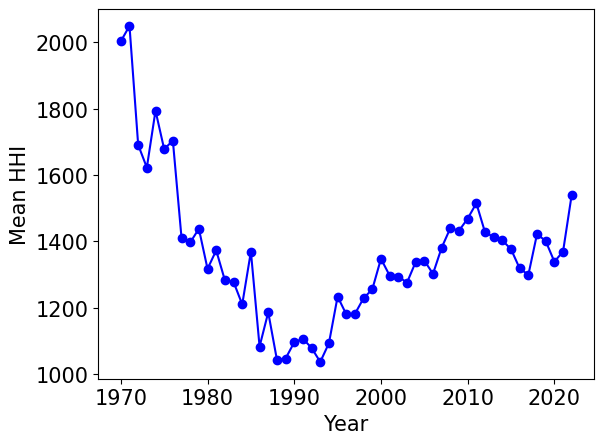

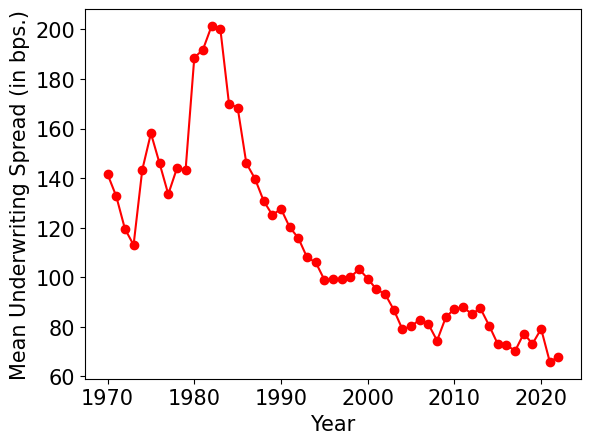

In [19]:
warnings.filterwarnings('ignore')

plt.plot(HHI_byCSA_Trimmed['calendar_year'], HHI_byCSA_Trimmed['hhi_by_N'], marker='o', linestyle='-', color='b')
plt.xlabel('Year',fontsize=15)
plt.ylabel('Mean HHI',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('../Draft/figs/Trend_HHI.eps', format='eps', bbox_inches='tight')
plt.show(block=False)

plt.plot(GPF_Trimmed['sale_year'], GPF_Trimmed['gross_spread'], marker='o', linestyle='-', color='r')
plt.xlabel('Year',fontsize=15)
plt.ylabel('Mean Underwriting Spread (in bps.)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('../Draft/figs/Trend_GrossSpread.eps', format='eps', bbox_inches='tight')
plt.show(block=False)

warnings.filterwarnings('default')